<a href="https://colab.research.google.com/github/gvnbleid/2020-GUM/blob/master/MGU_projekt_1a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sieć neuronowa


## Funkcje aktywacji

In [0]:
import numpy as np

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


def sigmoid_derivative(x):
    return sigmoid(x) * (1.0 - sigmoid(x))


def relu(x):
    return np.maximum(x, 0)


def relu_derivative(x):
    return np.where(x > 0, 1.0, 0.0)


def identity(x):
    return x


def identity_derivative(x):
    return np.array([[1] for i in x])


def tanh(x):
    return np.tanh(x)


def tanh_derivative(x):
    return 1.0 - np.square(np.tanh(x))

## Pochodne funkcji straty

In [0]:
def quadratic_cost_derivative(output_activations, y):
    return (output_activations - y)

def cross_entropy_cost_derivative(output_activations, y):
    return (output_activations - y)/((1-output_activations) * output_activations)

## Klasa sieci

In [0]:
import numpy as np
import pandas as pd
import json
import codecs
from enum import Enum

class TaskType(Enum):
    Classification = 1
    Regression = 2

class NeuralNetwork:

  def __init__(
      self,
      layer_sizes,
      activation_function,
      activation_function_deriv,
      output_function,
      output_function_deriv,
      cost_function_deriv,
      using_bias,
      taskType,
      seed = None
    ):
    self.layer_num = len(layer_sizes)
    self.layer_sizes = layer_sizes

    if(seed != None):
      np.random.seed(seed)

    self.edges_weights = [np.random.randn(x, y) for x, y in zip(layer_sizes[1:], layer_sizes[:-1])]
    self.biases_weights = [np.random.rand(x, 1) for x in layer_sizes[1:]]
    self.activation_function = activation_function
    self.activation_function_deriv = activation_function_deriv
    self.output_function = output_function
    self.output_function_deriv = output_function_deriv
    self.cost_function_deriv = cost_function_deriv
    self.using_bias = using_bias
    self.weighted_sums = []
    self.activations = []
    self.last_delta_weight = None
    self.last_delta_biases = None
    self.moment_factor = None
    self.learning_factor = None
    self.batch_size = None
    self.epoch_num = None
    self.history = []
    self.taskType = taskType
    self.classification_area_probing = []

  def backpropagate(self, net_input, desired_output):
    delta_weight = [np.zeros(es.shape) for es in self.edges_weights]
    delta_biases = [np.zeros(bs.shape) for bs in self.biases_weights]

    self.activations = []
    self.weighted_sums = []

    if(self.using_bias):
      net_output = self.feed_forward(net_input)
    else:
      net_output = self.feed_forward_no_bias(net_input)

    cost_per_node = self.cost_function_deriv(net_output, desired_output)
    ofd = self.output_function_deriv(self.weighted_sums[-1])
    d_per_node = cost_per_node * ofd
    
    delta_weight[-1] = np.dot(d_per_node, self.activations[-2].transpose())
    if(self.using_bias):
      delta_biases[-1] = d_per_node;

    for l in range(2, self.layer_num):
      ws = self.weighted_sums[-l]
      afd = self.activation_function_deriv(ws)
      d_per_node = np.dot(self.edges_weights[-l+1].transpose(), d_per_node) * afd
      
      delta_weight[-l] = np.dot(d_per_node, self.activations[-l-1].transpose())
      
      if(self.using_bias):
        delta_biases[-l] = d_per_node
      

    return (delta_weight, delta_biases)

  def feed_forward(self, net_input):
    tmp_output = net_input
    self.activations.append(net_input)

    for bias, layer_weights in zip(self.biases_weights[:-1], self.edges_weights[:-1]):
      layer_ws = np.dot(layer_weights, tmp_output) + bias
      self.weighted_sums.append(layer_ws)
      layer_activs = self.activation_function(layer_ws)
      self.activations.append(layer_activs)
      tmp_output = layer_activs

    layer_ws = np.dot(self.edges_weights[-1], tmp_output) + self.biases_weights[-1]
    self.weighted_sums.append(layer_ws)
    layer_activs = self.output_function(layer_ws)
    self.activations.append(layer_activs)
    return layer_activs

  def feed_forward_no_bias(self, net_input):
    tmp_output = net_input
    self.activations.append(net_input)

    for layer_weights in self.edges_weights[:-1]:
      layer_ws = np.dot(layer_weights, tmp_output)
      self.weighted_sums.append(layer_ws)
      layer_activs = self.activation_function(layer_ws)
      self.activations.append(layer_activs)
      tmp_output = layer_activs

    layer_ws = np.dot(self.edges_weights[-1], tmp_output)
    self.weighted_sums.append(layer_ws)
    layer_activs = self.output_function(layer_ws)
    self.activations.append(layer_activs)
    return layer_activs

  def learn(self, training_set, test_set, learning_factor, moment_factor, batch_size, epoch_num, probe=None):
    training_set_cp = training_set

    self.moment_factor = moment_factor
    self.learning_factor = learning_factor
    self.last_delta_biases = None
    self.last_delta_weight = None
    self.batch_size = batch_size
    self.epoch_num = epoch_num

    
    for i in range(epoch_num):
      np.random.shuffle(training_set_cp)
      batches = [training_set_cp[i * batch_size:(i + 1) * batch_size] 
               for i in range((len(training_set_cp) + batch_size - 1) // batch_size )]
      
      for batch, batch_id in zip(batches, range(1, 1 + len(batches))):
        sum_dw = [np.zeros(ew.shape) for ew in self.edges_weights]
        sum_db = [np.zeros(bs.shape) for bs in self.biases_weights]
        for ni, dno in batch:

          dw, db = self.backpropagate(ni, dno)
          sum_dw = [sdw + ndw for sdw, ndw in zip(sum_dw, dw)]
          if(self.using_bias):
            sum_db = [sdb + ndb for sdb, ndb in zip(sum_db, db)]
        
        if(self.last_delta_weight != None):
          sum_dw = [self.moment_factor * ldw + (1 - self.moment_factor) * sdw 
                    for sdw, ldw in zip(sum_dw, self.last_delta_weight)]
          if(self.using_bias):
            sum_db = [self.moment_factor * ldb + (1 - self.moment_factor) * sdb 
                      for sdb, ldb in zip(sum_db, self.last_delta_biases)]

        self.edges_weights = [ew - (learning_factor / len(batch)) * sdw for ew, sdw in zip(self.edges_weights, sum_dw)]
        
        if(self.using_bias):
          self.biases_weights = [bw - (learning_factor / len(batch)) * sdb for bw, sdb in zip(self.biases_weights, sum_db)]

        self.last_delta_biases = sum_db
        self.last_delta_weight = sum_dw

      test_acc = self.test_accuracy(test_set)
      train_acc = self.test_accuracy(training_set)

      # if(self.taskType == TaskType.Classification):
      #   print(f"Epoch {i}: [{batch_id}/{len(batches)}] - Accuracy: {test_acc}")
      # else:
      #   print(f"Epoch {i}: [{batch_id}/{len(batches)}] - MSE: {test_acc}")

      # self.loss = 0

      self.take_snapshot(f'Epoch {i}: ', train_acc, test_acc)

      if probe != None:
        self.classification_area_probing.append(self.classify(probe))
        
  def test_accuracy(self, test_data):
    if(self.taskType == TaskType.Classification):
      return self.validate_classification(test_data)
    else:
      return self.validate_regression(test_data)
  
  def validate_classification(self, data):
      correct = 0
      for x, y in data:
          expected = np.argmax(y)
          result = np.argmax(self.feed_forward(x))
          if expected == result:
              correct = correct + 1
      return correct / len(data)
  
  def validate_regression(self, data):
    error = 0
    for x, y in data:
        error = error + np.square(self.feed_forward(x)-y).mean()
    return error / len(data)

  def classify(self, test_data):
        results = []
        for x in test_data:
            classification = np.argmax(self.feed_forward(x))
            results.append(classification)
        return results
  
  def run_regression(self, test_data):
        results = []
        for x in test_data:
            regression = self.feed_forward(x)
            results.append(regression)
        return results
      
  def take_snapshot(self, name, train_accuracy=None, test_accuracy=None):
    if(self.using_bias):
      dump = dict(biases=[bias.tolist() for bias in self.biases_weights],
                  weight_matrix=[weight.tolist() for weight in self.edges_weights],
                  name=name,
                  train_fitness=train_accuracy,
                  test_fitness=test_accuracy)
    else:
      dump = dict(weight_matrix=[weight.tolist() for weight in self.edges_weights],
                  name=name,
                  train_fitness=train_accuracy,
                  test_fitness=test_accuracy)
      
    self.history.append(dump)

  def save_history(self, out_filepath):
    network_info = dict(
        sizes=self.layer_sizes, learning_factor=self.learning_factor,
        moment_factor=self.moment_factor,
        epoch_num=self.epoch_num, batch_size=self.batch_size,
        activation_function=self.activation_function.__name__,
        output_function=self.output_function.__name__)
    json.dump(dict(history=self.history, network_info=network_info),
              codecs.open(out_filepath, 'w', encoding='utf-8'))

## Podpięcie dysku i wczytywanie danych

### Podpięcie dysku

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
BASE_DIR = '/content/gdrive/My Drive/DL2020/Projekt1a'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Ładowanie danych

In [0]:
import numpy as np
import pandas as pd
import os

def load_classification_wrapper(path, name, train_size, test_size=None):
    if test_size == None:
        test_size = train_size

    train = load_classification(os.path.join(
        path, f'{name}.train.{train_size}.csv'), ['x', 'y'])
    test = load_classification(os.path.join(
        path, f'{name}.test.{test_size}.csv'), ['x', 'y'])
    return (train, test)


def load_classification(csv_filename, argument_column_names, class_column_name='cls'):
    df = pd.read_csv(csv_filename)

    output_layer_neuron_count = len(df[class_column_name].unique())
    input_layer_neuron_count = len(argument_column_names)

    training_data = []

    for row in df.itertuples():
        x = np.zeros((input_layer_neuron_count, 1))

        for i in range(len(argument_column_names)):
            x[i] = getattr(row, argument_column_names[i])

        y = vectorize_class(getattr(row, class_column_name),
                            output_layer_neuron_count)

        training_data.append((x, y))
    return training_data

def load_regression(csv_filename, input_column_names, output_column_names):
    df = pd.read_csv(csv_filename)

    output_layer_neuron_count = len(output_column_names)
    input_layer_neuron_count = len(input_column_names)

    training_data = []

    for row in df.itertuples():
        x = np.zeros((input_layer_neuron_count, 1))
        y = np.zeros((output_layer_neuron_count, 1))

        for i in range(len(input_column_names)):
            x[i] = getattr(row, input_column_names[i])

        for i in range(len(output_column_names)):
            y[i] = getattr(row, output_column_names[i])

        training_data.append((x, y))
    return training_data

def load_regression_wrapper(path, name, train_size, test_size=None):
    if test_size == None:
        test_size = train_size

    train = load_regression(os.path.join(
        path, f'{name}.train.{train_size}.csv'), ['x'], ['y'])
    test = load_regression(os.path.join(
        path, f'{name}.test.{test_size}.csv'), ['x'], ['y'])
    return (train, test)


def vectorize_class(class_id, class_length):
    # assume that classification starts at 1 to class_length, e.g. 1,2,3,4
    class_id = class_id - 1
    y = np.zeros((class_length, 1))
    y[class_id] = 1
    return y

## Odpalenie sieci

### Klasyfikacja

In [6]:
from datetime import datetime

train, test = load_classification_wrapper(BASE_DIR + r'/data/classification', 'data.three_gauss', 100)
inp_lay_size = len(train[0][0])
out_lay_size = len(train[0][1])
np.random.seed(11)
nn = NeuralNetwork([inp_lay_size, 8, out_lay_size], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, quadratic_cost_derivative, True, TaskType.Classification)
nn.learn(train, test, 0.9, 0.3, 20, 500)

now = datetime.now()
current_time = now.strftime("%H:%M:%S")

nn.save_history(BASE_DIR + f'/results/classification_{current_time}.json')

KeyboardInterrupt: ignored

### Regresja

In [0]:
from datetime import datetime

train, test = load_regression_wrapper(BASE_DIR + r'/data/regression', 'data.activation', 100)
inp_lay_size = len(train[0][0])
out_lay_size = len(train[0][1])
np.random.seed(0)
nn = NeuralNetwork([inp_lay_size, 5, out_lay_size], sigmoid, sigmoid_derivative, identity, identity_derivative, quadratic_cost_derivative, True, TaskType.Regression)
nn.learn(train, test, 0.1, 0, 20, 100)

now = datetime.now()
current_time = now.strftime("%H:%M:%S")

nn.save_history(BASE_DIR + f'/results/regression_{current_time}.json')

## Testy

### Feed forward

In [0]:
np.random.seed(0)
l_sizes = [2,2,2]
w = [np.random.randn(x, y) * 0.01 for x, y in zip(l_sizes[1:], l_sizes[:-1])]
b = [np.random.rand(x, 1) for x in l_sizes[1:]]

inp = np.array([[1], [1]])
res2 = inp
for ww, bb in zip(w, b):
  res2 = identity(np.dot(ww, res2) + bb)

net = NeuralNetwork([2, 2, 2], identity, identity_derivative, identity, identity_derivative, quadratic_cost_derivative, True, TaskType.Classification, 0)
res = net.feed_forward(inp)
print(res)
print(res2)

### Błąd = 0

In [0]:
np.random.seed(0)
l_sizes = [2,2,2]
output = np.array([[0.80606424], [0.53762709]])
inp = np.array([[1], [1]])

net = NeuralNetwork([2, 2, 2], identity, identity_derivative, identity, identity_derivative, quadratic_cost_derivative, True, TaskType.Classification, 0)
w, b = net.backpropagate(inp, output)
print(w)
print(b)

### Uczenie nauczonej sieci

In [0]:
np.random.seed(0)
l_sizes = [2,2,2]
w = [np.random.randn(x, y) * 0.01 for x, y in zip(l_sizes[1:], l_sizes[:-1])]
b = [np.random.rand(x, 1) for x in l_sizes[1:]]

training_set = [(np.array([[1], [1]]), np.array([[0.80606424], [0.53762709]]))]
test_set = [(np.array([[1], [1]]), np.array([[0.80606424], [0.53762709]]))]

net = NeuralNetwork([2, 2, 2], identity, identity_derivative, identity, identity_derivative, quadratic_cost_derivative, True, TaskType.Classification, 0)
net.learn(training_set, test_set, 0.1, 0.1, 1, 1)
print(net.feed_forward(np.array([[1], [1]])))

## Wyniki

###Funkcje pomocnicze

In [0]:
def create_filename(figure_name, data_name, epochs, batch_size, task_type):
    return BASE_DIR + f'/results/{task_type}/{figure_name}{task_type}__{data_name.split(".")[1]}__{epochs}_{batch_size}.png'

def create_heatmap(min_x, max_x, min_y, max_y, count_x, count_y):
    step_x = (max_x - min_x) / count_x
    step_y = (max_y - min_y) / count_y
    probes_x = []
    probes_y = []
    probes_input = []
    for x_i in range(count_x):
        for y_i in range(count_y):
            x = min_x + x_i * step_x
            y = min_y + y_i * step_y
            probes_x.append(x)
            probes_y.append(y)
            input_x = np.zeros((2, 1))
            input_x[0] = x
            input_x[1] = y
            probes_input.append(input_x)
    return probes_x, probes_y, probes_input

### Wyniki klasyfikacji

#### Wizualizacja zbioru uczącego oraz rezultatów klasyfikacji

In [0]:
import matplotlib.pyplot as plot

def visualize_classification(seed, hidden_layer_sizes, hidden_layers_activation_function, hidden_layers_activation_function_prime, output_layer_activation_function, output_layer_activation_function_prime, cost_derivative, is_bias_enabled, path, data_name, train_size,  epochs, batch_size, eta, alpha, test_size=None):
    global nn
    train_data, test_data = load_classification_wrapper(path, data_name, train_size, test_size)
    np.random.seed(seed)
    sizes = [len(train_data[0][0])]
    sizes.extend(hidden_layer_sizes)
    sizes.append(len(train_data[0][1]))
    nn = NeuralNetwork(sizes, hidden_layers_activation_function, hidden_layers_activation_function_prime, output_layer_activation_function, output_layer_activation_function_prime, cost_derivative, is_bias_enabled, TaskType.Classification)

    x = [entry[0][0][0] for entry in test_data]
    y = [entry[0][1][0] for entry in test_data]

    probes_x, probes_y, probes_input = create_heatmap(
        min(x), max(x), min(y), max(y), 300, 300)

    nn.learn(train_data, test_data, eta, alpha, batch_size, epochs, probe=probes_input)
    
    # classification points visualization
    valid_classification = [np.argmax(entry[1]) for entry in test_data]
    net_classification = nn.classify([x for (x, y) in test_data])
    x = [entry[0][0][0] for entry in test_data]
    y = [entry[0][1][0] for entry in test_data]

    plot.scatter(x=x, y=y, c=net_classification)
    plot.axis('equal')
    plot.title(f'classification results for {data_name} size {train_size}')
    plot.xlabel('x')
    plot.ylabel('y')
    plot.savefig(create_filename('results-', data_name, epochs, batch_size, 'classification'), dpi=150)
    plot.show()
    plot.clf()

    # classificaiton area probing

    for probe_classification, epoch in zip(nn.classification_area_probing, range(len(nn.classification_area_probing))):
        plot.scatter(x=probes_x, y=probes_y, c=probe_classification)
        plot.axis('equal')
        plot.title(f'probe classification for {data_name} size {train_size} epoch {epoch}')
        plot.xlabel('x')
        plot.ylabel('y')
        plot.savefig(create_filename(f'learning-{epoch}-', data_name, epochs, batch_size, 'classification'), dpi=150)
        plot.show()
        plot.clf()

visualize_classification(0, [5], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, quadratic_cost_derivative, True, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 10, 10, 0.9, 0)

#### Wykresy błędu

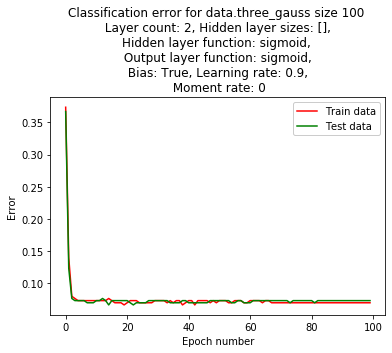

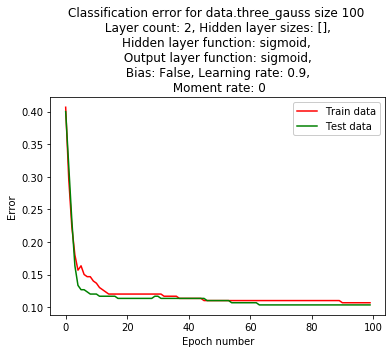

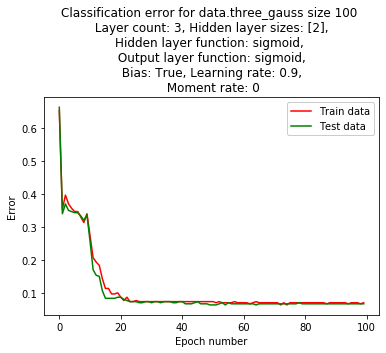

KeyboardInterrupt: ignored

In [12]:
import matplotlib.pyplot as plt

def visualize_error(seed, hidden_layer_sizes, hidden_layers_activation_function, hidden_layers_activation_function_prime, output_layer_activation_function, output_layer_activation_function_prime, cost_derivative, is_bias_enabled, path, data_name, train_size,  epochs, batch_size, eta, alpha, test_size=None):
  train_data, test_data = load_classification_wrapper(path, data_name, train_size, test_size)
  np.random.seed(seed)
  sizes = [len(train_data[0][0])]
  sizes.extend(hidden_layer_sizes)
  sizes.append(len(train_data[0][1]))
  nn = NeuralNetwork(sizes, hidden_layers_activation_function, hidden_layers_activation_function_prime, output_layer_activation_function, output_layer_activation_function_prime, cost_derivative, is_bias_enabled, TaskType.Classification, seed)
  nn.learn(train_data, test_data, eta, alpha, batch_size, epochs)
  train_acc = []
  test_acc = []
  for dump in nn.history:
    train_acc.append(1 - dump["train_fitness"])
    test_acc.append(1 - dump["test_fitness"])
    
  plt.plot(range(nn.epoch_num), train_acc, 'r', label = 'Train data')
  plt.plot(range(nn.epoch_num), test_acc, 'g', label = 'Test data')
  plt.xlabel("Epoch number")
  plt.ylabel("Error")
  plt.title(f"Classification error for {data_name} size {train_size} \n Layer count: {len(sizes)}, Hidden layer sizes: {hidden_layer_sizes}, \n"  + \
            f"Hidden layer function: {hidden_layers_activation_function.__name__}, \n Output layer function: {output_layer_activation_function.__name__}, \n Bias: {is_bias_enabled}, " + \
            f"Learning rate: {eta}, \n Moment rate: {alpha}")
  plt.legend(framealpha=1, frameon=True);
  plt.show()

visualize_error(0, [], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, quadratic_cost_derivative, True, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, quadratic_cost_derivative, False, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, quadratic_cost_derivative, True, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, quadratic_cost_derivative, False, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [5], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, quadratic_cost_derivative, True, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [5], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, quadratic_cost_derivative, False, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [2, 2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, quadratic_cost_derivative, True, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [2, 2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, quadratic_cost_derivative, False, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [5, 3], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, quadratic_cost_derivative, True, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [5, 3], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, quadratic_cost_derivative, False, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [2, 2, 2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, quadratic_cost_derivative, True, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [2, 2, 2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, quadratic_cost_derivative, False, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [2, 5, 2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, quadratic_cost_derivative, True, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [2, 5, 2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, quadratic_cost_derivative, False, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [2, 2, 2, 2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, quadratic_cost_derivative, True, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [2, 2, 2, 2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, quadratic_cost_derivative, False, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [5, 4, 3, 2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, quadratic_cost_derivative, True, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [5, 4, 3, 2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, quadratic_cost_derivative, False, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)

visualize_error(0, [], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, cross_entropy_cost_derivative, True, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, cross_entropy_cost_derivative, False, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, cross_entropy_cost_derivative, True, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, cross_entropy_cost_derivative, False, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [5], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, cross_entropy_cost_derivative, True, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [5], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, cross_entropy_cost_derivative, False, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [2, 2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, cross_entropy_cost_derivative, True, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [2, 2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, cross_entropy_cost_derivative, False, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [5, 3], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, cross_entropy_cost_derivative, True, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [5, 3], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, cross_entropy_cost_derivative, False, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [2, 2, 2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, cross_entropy_cost_derivative, True, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [2, 2, 2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, cross_entropy_cost_derivative, False, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [2, 5, 2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, cross_entropy_cost_derivative, True, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [2, 5, 2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, cross_entropy_cost_derivative, False, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [2, 2, 2, 2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, cross_entropy_cost_derivative, True, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [2, 2, 2, 2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, cross_entropy_cost_derivative, False, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [5, 4, 3, 2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, cross_entropy_cost_derivative, True, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)
visualize_error(0, [5, 4, 3, 2], sigmoid, sigmoid_derivative, sigmoid, sigmoid_derivative, cross_entropy_cost_derivative, False, BASE_DIR + r'/data/classification', 'data.three_gauss', 100, 100, 10, 0.9, 0)

###Wyniki regresji

Wizualizacja zbioru uczącego oraz rezultatów regresji

In [0]:
import matplotlib.pyplot as plot

def visualize_regression(seed, hidden_layer_sizes, hidden_layers_activation_function, hidden_layers_activation_function_prime, output_layer_activation_function, output_layer_activation_function_prime, cost_derivative, is_bias_enabled, path, data_name, train_size,  epochs, batch_size, eta, alpha, test_size=None):
    global nn
    train_data, test_data = load_regression_wrapper(path, data_name, train_size, test_size)
    np.random.seed(seed)
    sizes = [len(train_data[0][0])]
    sizes.extend(hidden_layer_sizes)
    sizes.append(len(train_data[0][1]))
    nn = NeuralNetwork(sizes, hidden_layers_activation_function, hidden_layers_activation_function_prime, output_layer_activation_function, output_layer_activation_function_prime, cost_derivative, is_bias_enabled, TaskType.Regression)

    #x = [entry[0][0][0] for entry in test_data]
    #y = [entry[0][1][0] for entry in test_data]

    #probes_x, probes_y, probes_input = create_heatmap(
    #    min(x), max(x), min(y), max(y), 300, 300)

    nn.learn(train_data, test_data, eta, alpha, batch_size, epochs)#, probe=probes_input)
    
    # regression points visualization
    y_pred = nn.run_regression([x for (x, y) in test_data])
    x = [entry[0][0][0] for entry in test_data]
    y_true = [y for (x, y) in test_data]

    min_x = min(x)
    max_x = max(x)

    plot.scatter(x=x, y=y_true, c='b', label='y_true')
    plot.scatter(x=x, y=y_pred, c='r', label='y_pred')
    plot.xlim(min_x, max_x)
    plot.title(f'regression results for {data_name} size {train_size}')
    plot.xlabel('x')
    plot.ylabel('y')
    plot.legend(loc='upper left')
    plot.savefig(create_filename('results-', data_name, epochs, batch_size, 'regression'), dpi=150)
    plot.show()
    plot.clf()

    # regression area probing

    #for probe_classification, epoch in zip(nn.classification_area_probing, range(len(nn.classification_area_probing))):
    #    pyplot.scatter(x=probes_x, y=probes_y, c=probe_classification)
    #    pyplot.axis('equal')
    #    pyplot.savefig(create_filename(f'learning-{epoch}-', data_name, epochs, batch_size, 'regression'), dpi=150)
    #    pyplot.show()
    #    pyplot.clf()

visualize_regression(0, [5], sigmoid, sigmoid_derivative, identity, identity_derivative, quadratic_cost_derivative, True, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 20, 0.1, 0)

#### Wykresy błędu

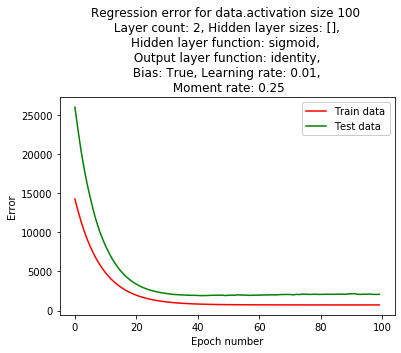

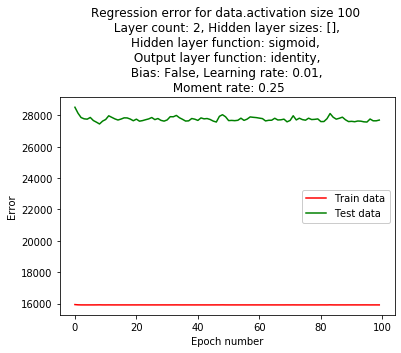

KeyboardInterrupt: ignored

In [14]:
import matplotlib.pyplot as plt

def visualize_error(seed, hidden_layer_sizes, hidden_layers_activation_function, hidden_layers_activation_function_prime, output_layer_activation_function, output_layer_activation_function_prime, cost_derivative, is_bias_enabled, path, data_name, train_size,  epochs, batch_size, eta, alpha, test_size=None):
  train_data, test_data = load_regression_wrapper(path, data_name, train_size, test_size)
  np.random.seed(seed)
  sizes = [len(train_data[0][0])]
  sizes.extend(hidden_layer_sizes)
  sizes.append(len(train_data[0][1]))
  nn = NeuralNetwork(sizes, hidden_layers_activation_function, hidden_layers_activation_function_prime, output_layer_activation_function, output_layer_activation_function_prime, cost_derivative, is_bias_enabled, TaskType.Regression, seed)
  nn.learn(train_data, test_data, eta, alpha, batch_size, epochs)
  train_err = []
  test_err = []
  for dump in nn.history:
    train_err.append(dump["train_fitness"])
    test_err.append(dump["test_fitness"])
  plt.plot(range(nn.epoch_num), train_err, 'r', label='Train data')
  plt.plot(range(nn.epoch_num), test_err, 'g', label='Test data')
  plt.xlabel("Epoch number")
  plt.ylabel("Error")
  plt.title(f"Regression error for {data_name} size {train_size} \n Layer count: {len(sizes)}, Hidden layer sizes: {hidden_layer_sizes}, \n"  + \
            f"Hidden layer function: {hidden_layers_activation_function.__name__}, \n Output layer function: {output_layer_activation_function.__name__}, \n Bias: {is_bias_enabled}, " + \
            f"Learning rate: {eta}, \n Moment rate: {alpha}")
  plt.legend(framealpha=1, frameon=True);
  plt.show()

visualize_error(0, [], sigmoid, sigmoid_derivative, identity, identity_derivative, quadratic_cost_derivative, True, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.01, 0.25)
visualize_error(0, [], sigmoid, sigmoid_derivative, identity, identity_derivative, quadratic_cost_derivative, False, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.01, 0.25)
visualize_error(0, [2], sigmoid, sigmoid_derivative, identity, identity_derivative, quadratic_cost_derivative, True, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.01, 0.25)
visualize_error(0, [2], sigmoid, sigmoid_derivative, identity, identity_derivative, quadratic_cost_derivative, False, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.01, 0.25)
visualize_error(0, [5], sigmoid, sigmoid_derivative, identity, identity_derivative, quadratic_cost_derivative, True, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.01, 0.25)
visualize_error(0, [5], sigmoid, sigmoid_derivative, identity, identity_derivative, quadratic_cost_derivative, False, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.01, 0.25)
visualize_error(0, [2, 2], sigmoid, sigmoid_derivative, identity, identity_derivative, quadratic_cost_derivative, True, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.01, 0.25)
visualize_error(0, [2, 2], sigmoid, sigmoid_derivative, identity, identity_derivative, quadratic_cost_derivative, False, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.01, 0.25)
visualize_error(0, [5, 3], sigmoid, sigmoid_derivative, identity, identity_derivative, quadratic_cost_derivative, True, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.01, 0.25)
visualize_error(0, [5, 3], sigmoid, sigmoid_derivative, identity, identity_derivative, quadratic_cost_derivative, False, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.01, 0.25)
visualize_error(0, [2, 2, 2], sigmoid, sigmoid_derivative, identity, identity_derivative, quadratic_cost_derivative, True, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.01, 0.25)
visualize_error(0, [2, 2, 2], sigmoid, sigmoid_derivative, identity, identity_derivative, quadratic_cost_derivative, False, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.01, 0.25)
visualize_error(0, [2, 5, 2], sigmoid, sigmoid_derivative, identity, identity_derivative, quadratic_cost_derivative, True, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.01, 0.25)
visualize_error(0, [2, 5, 2], sigmoid, sigmoid_derivative, identity, identity_derivative, quadratic_cost_derivative, False, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.01, 0.25)
visualize_error(0, [2, 2, 2, 2], sigmoid, sigmoid_derivative, identity, identity_derivative, quadratic_cost_derivative, True, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.01, 0.25)
visualize_error(0, [2, 2, 2, 2], sigmoid, sigmoid_derivative, identity, identity_derivative, quadratic_cost_derivative, False, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.01, 0.25)
visualize_error(0, [5, 4, 3, 2], sigmoid, sigmoid_derivative, identity, identity_derivative, quadratic_cost_derivative, True, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.01, 0.25)
visualize_error(0, [5, 4, 3, 2], sigmoid, sigmoid_derivative, identity, identity_derivative, quadratic_cost_derivative, False, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.01, 0.25)

visualize_error(0, [], sigmoid, sigmoid_derivative, identity, identity_derivative, cross_entropy_cost_derivative, True, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.1, 0)
visualize_error(0, [], sigmoid, sigmoid_derivative, identity, identity_derivative, cross_entropy_cost_derivative, False, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.1, 0)
visualize_error(0, [2], sigmoid, sigmoid_derivative, identity, identity_derivative, cross_entropy_cost_derivative, True, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.1, 0)
visualize_error(0, [2], sigmoid, sigmoid_derivative, identity, identity_derivative, cross_entropy_cost_derivative, False, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.1, 0)
visualize_error(0, [5], sigmoid, sigmoid_derivative, identity, identity_derivative, cross_entropy_cost_derivative, True, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.1, 0)
visualize_error(0, [5], sigmoid, sigmoid_derivative, identity, identity_derivative, cross_entropy_cost_derivative, False, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.1, 0)
visualize_error(0, [2, 2], sigmoid, sigmoid_derivative, identity, identity_derivative, cross_entropy_cost_derivative, True, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.1, 0)
visualize_error(0, [2, 2], sigmoid, sigmoid_derivative, identity, identity_derivative, cross_entropy_cost_derivative, False, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.1, 0)
visualize_error(0, [5, 3], sigmoid, sigmoid_derivative, identity, identity_derivative, cross_entropy_cost_derivative, True, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.1, 0)
visualize_error(0, [5, 3], sigmoid, sigmoid_derivative, identity, identity_derivative, cross_entropy_cost_derivative, False, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.1, 0)
visualize_error(0, [2, 2, 2], sigmoid, sigmoid_derivative, identity, identity_derivative, cross_entropy_cost_derivative, True, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.1, 0)
visualize_error(0, [2, 2, 2], sigmoid, sigmoid_derivative, identity, identity_derivative, cross_entropy_cost_derivative, False, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.1, 0)
visualize_error(0, [2, 5, 2], sigmoid, sigmoid_derivative, identity, identity_derivative, cross_entropy_cost_derivative, True, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.1, 0)
visualize_error(0, [2, 5, 2], sigmoid, sigmoid_derivative, identity, identity_derivative, cross_entropy_cost_derivative, False, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.1, 0)
visualize_error(0, [2, 2, 2, 2], sigmoid, sigmoid_derivative, identity, identity_derivative, cross_entropy_cost_derivative, True, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.1, 0)
visualize_error(0, [2, 2, 2, 2], sigmoid, sigmoid_derivative, identity, identity_derivative, cross_entropy_cost_derivative, False, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.1, 0)
visualize_error(0, [5, 4, 3, 2], sigmoid, sigmoid_derivative, identity, identity_derivative, cross_entropy_cost_derivative, True, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.1, 0)
visualize_error(0, [5, 4, 3, 2], sigmoid, sigmoid_derivative, identity, identity_derivative, cross_entropy_cost_derivative, False, BASE_DIR + r'/data/regression', 'data.activation', 100, 100, 10, 0.1, 0)